In [14]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
#import alipy

In [15]:
quasJ = os.listdir('/media/lynge/Lynge-Back-up/NGC3783/NGC3783g/')
quasJ = [os.path.join('/media/lynge/Lynge-Back-up/NGC3783/NGC3783g/',f) \
        for f in os.listdir('/media/lynge/Lynge-Back-up/NGC3783/NGC3783g/')]

qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
gal_RA_WORLD = 174.69151250 + 0.6/3600.# Galaxy
gal_DEC_WORLD = -37.71181944 + 0.4/3600

sky_RA_WORLD = 174.75445032458904 #Random patch of sky
sky_DEC_WORLD = -37.77465736280882

MAG_STA1_B = 9.23
MAG_STA1_V = 9.12
MAG_STA1_G = 9.192
MAG_STA1_J = float('nan')
MAG_STA1_H = float('nan')
MAG_STA1_K = float('nan')

MAG_STA1_g = 9.1124
MAG_STA1_r = 9.5110
MAG_STA1_i = float('nan')
MAG_STA1_z = 10.3072

MAG_STA2_B = 12.58
MAG_STA2_V = 12.12
MAG_STA2_G = 11.78
MAG_STA2_J = 10.919
MAG_STA2_H = 10.726
MAG_STA2_K = 10.611

MAG_STA2_g = 13.1053 #11.7892
MAG_STA2_r = 12.702 #11.6444
MAG_STA2_i = 12.656
MAG_STA2_z = float('nan') #11.5203

MAG_STA3_B = 11.61
MAG_STA3_V = 10.94
MAG_STA3_G = 10.867
MAG_STA3_J = 9.902
MAG_STA3_H = 9.625
MAG_STA3_K = 9.580

MAG_STA3_g = float('nan') #14.731
MAG_STA3_r = float('nan') #13.270
MAG_STA3_i = float('nan') #12.955
MAG_STA3_z = float('nan') #13.230

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

MAG_VEGA_g = -0.08
MAG_VEGA_r = 0.16
MAG_VEGA_i = 0.37
MAG_VEGA_z = 0.54

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_LAMBDA_VEGA_g = 466.9*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_r = 278.0*10**(-11)
FLUX_LAMBDA_VEGA_i = 185.2*10**(-11)
FLUX_LAMBDA_VEGA_z = 131.5*10**(-11)


FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

FLUX_V_VEGA_g = 3.631*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_r = 3.631*10**(-20)
FLUX_V_VEGA_i = 3.631*10**(-20)
FLUX_V_VEGA_z = 3.631*10**(-20)


In [16]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [17]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [18]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [19]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [20]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [21]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":10, 'DETECT_MINAREA':35, 'DETECT_MAXAREA':300000, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [22]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain

        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 25. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 25. and \
            DECmain - 25. < out['table']['YMODEL_IMAGE'][j] < DECmain + 25.:
                #print 'YES'
                output = out['table']['FLUX_APER'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [23]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN'])*data1_2*header['EXPTIME']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['EXPTIME'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['EXPTIME']
                                                         
                                                         +npix1*header['RONOISE']**2))

def SNR11(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['EXPTIME']))

def SNR22(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN']*npix1*data2_2*header['EXPTIME'])

def SNR33(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float((npix1*header['RONOISE']**2))

def SNR44(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['EXPTIME'] + 
                  header['GAIN']*npix1*data2_2*header['EXPTIME'] +
                  npix1*header['RONOISE']**2))

#SNRas(10.,data1_2,abs(data2_2),0,header['RONOISE'],npix1,gain=header['GAIN'])

for i in range(len(quasJ)):
    print i
    data1, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    data2 = data1
    #print header['CTYPE2']
    header['CTYPE1'] = "RA---TAN -SIP"
    header['CTYPE2'] = "DEC--TAN -SIP"
    #a_sky = curve(data2,header,WCS(quasJ[i]),
    #               (sky_RA_WORLD,sky_DEC_WORLD),0.002)[0]
    #a_sky_mean = np.mean(a_sky)
    #for j in range(len(np.shape(data[0]))):
    #    for k in range(len(np.shape(data[0]))):
    #        if data[j,k] != 0:
    #            data[j,k] = float(data[j,k]) - a_sky_mean
    #header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data1,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [24]:
a = np.array([[0,2],
              [3,4]])
b = np.mean(np.array([[1,2,3],
                      [2,2,2],
                      [1,1,1]]))

a = a.astype(float)
mask = a != 0.
a[mask] = a[mask] - float(b)
print a

[[ 0.          0.33333333]
 [ 1.33333333  2.33333333]]


In [25]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),6))
    SNR_array = np.zeros((len(quas),8))
    SNR_part = np.zeros((len(quas),5))
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['EXPTIME']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['EXPTIME']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['EXPTIME']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['EXPTIME']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['EXPTIME']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        SNR1 = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        comp_array[i,4] = SNR1
        comp_array[i,5] = a_AGN
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN, a2, a3, a4
        SNR_part[i,0] = date[i]
        SNR_part[i,1] = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,2] = SNR11(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,3] = SNR22(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,4] = SNR33(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    
    comp_array[:,1] = float('nan') #comp_array[:,1]*flux_cal(MAG_STA1_g,MAG_VEGA_g,FLUX_LAMBDA_VEGA_g)
    comp_array[:,2] = comp_array[:,2]*flux_cal(MAG_STA2_g,MAG_VEGA_g,FLUX_LAMBDA_VEGA_g)
    comp_array[:,3] = comp_array[:,3]*flux_cal(MAG_STA3_g,MAG_VEGA_g,FLUX_LAMBDA_VEGA_g)

    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,SNR_part

In [26]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1,SNR_part_1 = SEXAGNflux(quasJ,0.001)

Frame nr.  0 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016119URs025.fits
4234.10833333 132066.733333 10654.8533333 nan
Frame nr.  1 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016119URs026.fits
4234.97666667 134880.6 10641.5633333 nan
Frame nr.  2 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016119URs027.fits
4266.22166667 128317.35 10761.8433333 nan
Frame nr.  3 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016127URs030.fits
3426.17666667 107878.516667 8673.60833333 19574.3833333
Frame nr.  4 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016127URs031.fits
4069.03 123288.0 10416.6433333 23320.3333333
Frame nr.  5 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016127URs032.fits
4040.43666667 115489.35 10322.9183333 23297.6833333
Frame nr.  6 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016134URs063.fits
672.863166667 31944.3333333 1925.42666667 nan
Frame nr.  7 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016134URs064.fits
1284.367 59468.6333333 3618.26166667 nan

3007.85166667 107203.666667 6048.07833333 nan
Frame nr.  70 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017031URs111.fits
3020.03833333 103214.866667 6046.195 nan
Frame nr.  71 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017031URs112.fits
3015.40666667 104720.033333 6062.18166667 nan
Frame nr.  72 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017039URs093.fits
3074.94666667 114920.716667 6186.21666667 nan
Frame nr.  73 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017039URs094.fits
3076.44833333 115765.566667 6217.39166667 nan
Frame nr.  74 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017039URs095.fits
3064.37333333 115366.4 6264.61166667 nan
Frame nr.  75 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017046URs067.fits
2849.26666667 106428.266667 6653.04833333 14977.7433333
Frame nr.  76 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016165URs095.fits
1053.1215 52111.8666667 3347.12666667 nan
Frame nr.  77 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2016210URs022.f

2697.305 99165.4333333 5219.09666667 nan
Frame nr.  139 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017194URs019.fits
2700.605 98206.9 5209.725 nan
Frame nr.  140 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017201URs029.fits
3809.57166667 106592.316667 7103.825 nan
Frame nr.  141 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017201URs030.fits
3792.34833333 107991.3 7100.18166667 nan
Frame nr.  142 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017201URs031.fits
3821.085 106163.283333 7128.13333333 nan
Frame nr.  143 /media/lynge/Lynge-Back-up/NGC3783/NGC3783g/IMG2017210URs020.fits
1251.21883333 42901.7333333 2441.06833333 nan


In [27]:
print np.nanmean(comp_array[:,5]), np.nanstd(comp_array[:,5])
comp_array_mod = np.copy(comp_array)
comp_array_mod[comp_array[:,5] < np.nanmean(comp_array[:,5]) - 0.5*np.nanstd(comp_array[:,5]),1:5] = float('nan')


3013.95773183 829.268467427


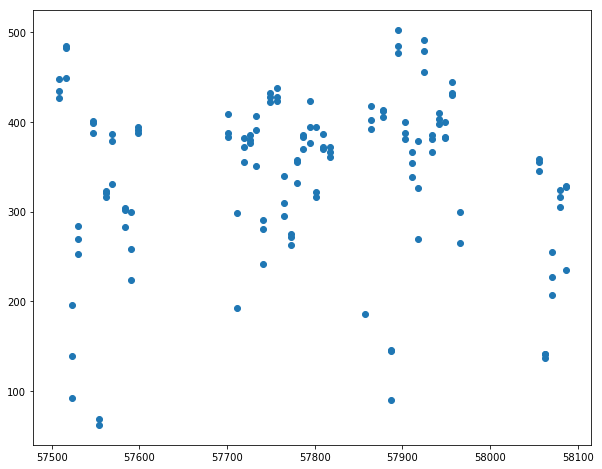

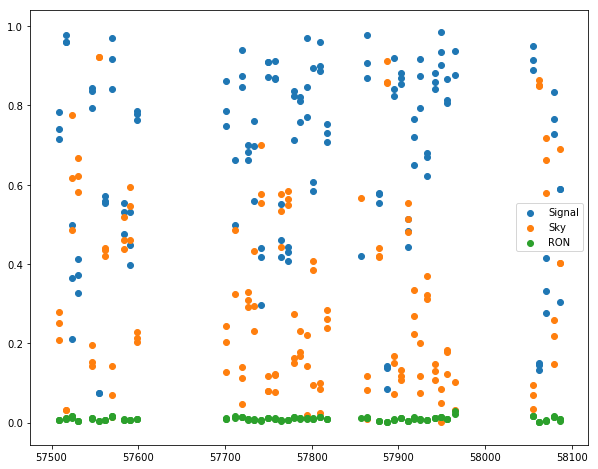

[ 57508.028564    57508.03061267  57508.03268356  57516.04011126
  57516.04215731  57516.04420141  57523.21306203  57523.21513501
  57523.21720414  57530.21721699  57530.21926346  57530.22130751
  57547.06797363  57547.07007225  57547.07211745  57554.21627609
  57554.22042105  57562.0924862   57562.09453456  57562.09657985
  57569.11800738  57569.12005476  57569.12210134  57583.99242811
  57583.99447691  57583.99652326  57591.01543977  57591.01748648
  57591.01953286  57598.99435381  57598.9964273   57691.31419669
  57691.31626777  57691.3183384   57693.38602007  57693.38806992
  57693.39011508  57701.34931631  57701.35136432  57701.35341182
  57711.35891381  57711.36096132  57711.36301689  57719.24791943
  57719.24999274  57719.25203789  57726.34417016  57726.34621747
  57733.35479247  57733.35686431  57733.35891081  57741.22674337
  57741.22955451  57741.23162675  57749.28157427  57749.28362152
  57749.28569214  57757.23207074  57757.23414352  57757.2362142
  57764.357062    57764.35

In [28]:
plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2],label='Signal')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3],label='Sky')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,4],label='RON')
plt.legend()
#plt.ylim([5*10**(-15),1.*10**(-14)])
plt.show()

print SNR_part_1[:,0]
np.savetxt('../NOVEMBER/NGC3783_SNR_g.txt',SNR_part_1)

In [29]:
print np.nanmean(comp_array[:,4])
print np.nanmean(comp_array_mod[:,4])

342.077786627
376.311653307


In [30]:
#print comp_array_mod
comp_array_mod_2 = np.zeros((len(comp_array_mod[:,0]),7))
#comp_array_mod_2[0,0] = comp_array_mod[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array_mod)):
    if comp_array_mod[i,0] != comp_array_mod_2[tjek,0]:
        comp_array_mod_2[tjek,0] = comp_array_mod[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array_mod)):
            if comp_array_mod_2[tjek,0] == comp_array_mod[j,0]:
                com1.append(comp_array_mod[j,1])
                com2.append(comp_array_mod[j,2])
                com3.append(comp_array_mod[j,3])
        comp_array_mod_2[tjek,1] = np.nanmean(com1)
        comp_array_mod_2[tjek,2] = np.nanstd(com1)
        if comp_array_mod_2[tjek,2]/float(comp_array_mod_2[tjek,1]) > acceptance or float(comp_array_mod_2[tjek,1]) < 0:
            comp_array_mod_2[tjek,1] = float('nan')
            comp_array_mod_2[tjek,2] = float('nan')
        comp_array_mod_2[tjek,3] = np.nanmean(com2)
        comp_array_mod_2[tjek,4] = np.nanstd(com2)
        if comp_array_mod_2[tjek,4]/float(comp_array_mod_2[tjek,3]) > acceptance or float(comp_array_mod_2[tjek,3]) < 0:
            comp_array_mod_2[tjek,3] = float('nan')
            comp_array_mod_2[tjek,4] = float('nan')
        comp_array_mod_2[tjek,5] = np.nanmean(com3)
        comp_array_mod_2[tjek,6] = np.nanstd(com3)
        if comp_array_mod_2[tjek,6]/float(comp_array_mod_2[tjek,5]) > acceptance or float(comp_array_mod_2[tjek,5]) < 0:
            comp_array_mod_2[tjek,5] = float('nan')
            comp_array_mod_2[tjek,6] = float('nan')
        tjek = tjek + 1

print comp_array_mod_2

np.savetxt('../NOVEMBER/NOV-NGC3783-g',comp_array_mod_2)

/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/lynge/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


[[  5.75080000e+04              nan              nan   9.86680872e-15
    1.58260045e-17              nan              nan]
 [  5.75080000e+04              nan              nan   9.86680872e-15
    1.58260045e-17              nan              nan]
 [  5.75080000e+04              nan              nan   9.86680872e-15
    1.58260045e-17              nan              nan]
 [  5.75160000e+04              nan              nan   9.74485307e-15
    4.74399927e-17              nan              nan]
 [  5.75160000e+04              nan              nan   9.74485307e-15
    4.74399927e-17              nan              nan]
 [  5.75160000e+04              nan              nan   9.74485307e-15
    4.74399927e-17              nan              nan]
 [  5.75230000e+04              nan              nan              nan
               nan              nan              nan]
 [  5.75230000e+04              nan              nan              nan
               nan              nan              nan]
 [  5.75

In [31]:
#print comp_array
comp_array_2 = np.zeros((len(comp_array[:,0]),13))
#comp_array_2[0,0] = comp_array[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array)):
    if comp_array[i,0] != comp_array_2[tjek,0]:
        comp_array_2[tjek,0] = comp_array[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array)):
            if comp_array_2[tjek,0] == comp_array[j,0]:
                com1.append(comp_array[j,1])
                com2.append(comp_array[j,2])
                com3.append(comp_array[j,3])
        comp_array_2[tjek,1] = np.mean(com1)
        comp_array_2[tjek,2] = np.std(com1)
        if comp_array_2[tjek,2]/float(comp_array_2[tjek,1]) > acceptance or float(comp_array_2[tjek,1]) < 0:
            comp_array_2[tjek,1] = float('nan')
            comp_array_2[tjek,2] = float('nan')
        comp_array_2[tjek,3] = np.mean(com2)
        comp_array_2[tjek,4] = np.std(com2)
        if comp_array_2[tjek,4]/float(comp_array_2[tjek,3]) > acceptance or float(comp_array_2[tjek,3]) < 0:
            comp_array_2[tjek,3] = float('nan')
            comp_array_2[tjek,4] = float('nan')
        comp_array_2[tjek,5] = np.mean(com3)
        comp_array_2[tjek,6] = np.std(com3)
        if comp_array_2[tjek,6]/float(comp_array_2[tjek,5]) > acceptance or float(comp_array_2[tjek,5]) < 0:
            comp_array_2[tjek,5] = float('nan')
            comp_array_2[tjek,6] = float('nan')
        tjek = tjek + 1

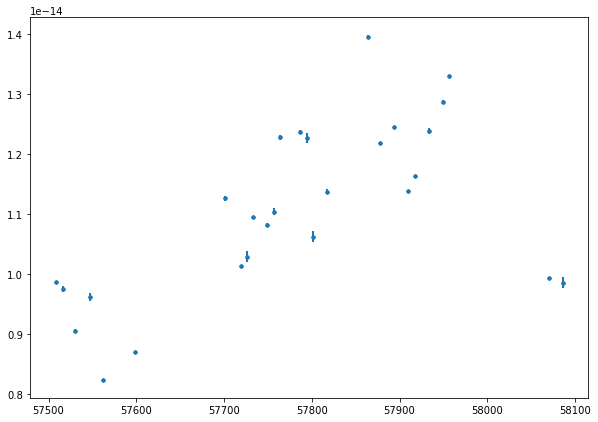

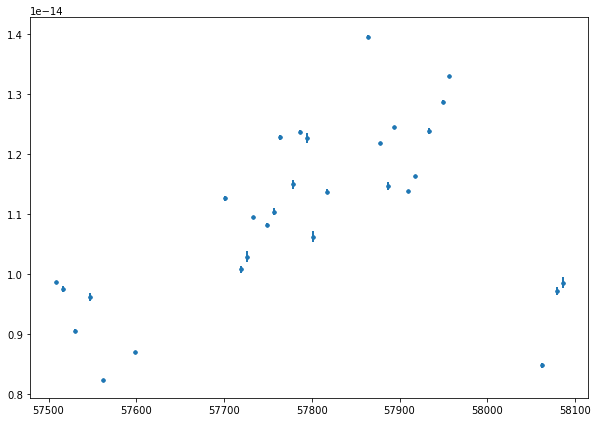

In [32]:
plt.figure(figsize=(10,7))
plt.errorbar(comp_array_mod_2[:,0],comp_array_mod_2[:,3],yerr=comp_array_mod_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(comp_array_2[:,0],comp_array_2[:,3],yerr=comp_array_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()


In [33]:
plt.figure(figsize=(20,14))
#plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
#            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.07*10**(-14),1*10**(-14)])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

num = np.nanargmax(ABS_FLUX_LAMBDA_2_1)

print ABS_FLUX_LAMBDA_2
print ABS_FLUX_LAMBDA_2[num]
print num
print date[num]
print quasJ[num]


NameError: name 'date' is not defined

In [ ]:
plt.figure(figsize=(20,14))
#plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
#            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
#plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
#            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.2*10**(-14),0.3*10**(-14)])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

num = np.nanargmax(ABS_FLUX_LAMBDA_2_1)

print ABS_FLUX_LAMBDA_2
print ABS_FLUX_LAMBDA_2[num]
print num
print date[num]
print quasJ[num]


In [ ]:

plt.figure(figsize=(10,7))
plt.scatter(date,flucompsta2,marker='x',\
            color='b',label='AGN/Tycho-2 7740-22-1')
plt.scatter(date,flucompsta1*6.2,marker='x',\
            color='r',label='AGN/HD 101274 (scaled by 4.7)')
#plt.scatter(date,flucompsta4*2.2,marker='x',\
#            color='g',label='AGN/Tycho-2 7740-529-1 (scaled by 2.2)')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
plt.ylim([1.45,2.1])
plt.legend()
plt.show()


